# LOG6302A — Analyse d’applications et Cyber-sécurité<br>Laboratoire #2

**Quentin Guidée (2206809), Nam Vu (2230468)**

Polytechnique Montréal – Hiver 2024


In [33]:
from code_analysis import AST, CFG, ASTReader

In [34]:
import tempfile

from graphviz.sources import Source
from IPython.display import Image

reader = ASTReader()


def show_cfg(cfg: CFG) -> Image:
    dot = cfg.to_dot()
    s = Source(dot)
    with tempfile.NamedTemporaryFile(suffix=".png") as f:
        s.render(f.name, format="png")
        return Image(f.name + ".png")

In [151]:
class ASTtoCFGVisitor:
    def __init__(self, ast: AST):
        self.ast = ast
        self.cfg = CFG()
        self.curr_nid = 0

        self.handlers = {
            "FunctionCall": self.visit_funccall,
            "BinOP": self.visit_binop,
            "Variable": self.visit_variable,
            "IfThenElseStatement": self.visit_ifelse,
            "Condition": self.visit_condition,
            "RelOP": self.visit_relop,
            "StatementBody": self.visit_statementbody,
            "Block": self.visit_block,
        }

    def get_new_nid(self) -> int:
        self.curr_nid += 1
        return self.curr_nid

    @classmethod
    def visit(cls, ast: AST) -> CFG:
        visitor = cls(ast)
        print(f"Visit AST from file {visitor.ast.get_filename()}")
        visitor.visit_root(ast.get_root())
        return visitor.cfg

    def visit_root(self, ast_nid: int) -> int:
        entry_nid = self.get_new_nid()
        self.cfg.set_root(entry_nid)
        self.cfg.set_type(entry_nid, "Entry")
        self.cfg.set_image(entry_nid, "main")
        self.cfg.set_node_ptr(ast_nid, entry_nid)

        exit_nid = self.get_new_nid()
        self.cfg.set_type(exit_nid, "Exit")

        last_child_nid = self.visit_block(ast_nid, entry_nid)
        self.cfg.add_edge(last_child_nid, exit_nid)

        return exit_nid

    def visit_block(self, ast_nid: int, parent_cfg_nid: int) -> int:
        children = self.ast.get_children(ast_nid)
        new_parent_cfg_nid = parent_cfg_nid
        for child_node in children:
            new_parent_cfg_nid = self.visit_node(child_node, new_parent_cfg_nid)
        return new_parent_cfg_nid

    def visit_node(self, ast_nid: int, parent_cfg_nid: int) -> int:
        node_type = self.ast.get_type(ast_nid)
        # print(f"Visiting node {ast_nid} ({node_type}) with parent {parent_cfg_nid}")
        # display(show_cfg(self.cfg))
        handler = self.handlers.get(node_type, self.visit_generic)
        return handler(ast_nid, parent_cfg_nid)

    def visit_funccall(self, ast_nid: int, parent_cfg_nid: int) -> int:
        funccall_nid = self.get_new_nid()
        self.cfg.set_type(funccall_nid, self.ast.get_type(ast_nid))
        self.cfg.set_image(funccall_nid, self.ast.get_image(ast_nid))
        self.cfg.set_node_ptr(ast_nid, funccall_nid)

        self.cfg.add_edge(parent_cfg_nid, funccall_nid)

        callbegin_nid = self.get_new_nid()
        self.cfg.set_type(callbegin_nid, "CallBegin")
        self.cfg.set_image(callbegin_nid, self.ast.get_image(ast_nid))

        callend_nid = self.get_new_nid()
        self.cfg.set_type(callend_nid, "CallEnd")
        self.cfg.set_image(callend_nid, self.ast.get_image(ast_nid))

        self.cfg.set_call(callbegin_nid, callend_nid)

        children = self.ast.get_children(ast_nid)
        assert len(children) == 2
        id_node, arglist_node = children[0], children[1]

        id_cfg_nid = self.visit_node(id_node, funccall_nid)
        self.cfg.set_call_expr(callbegin_nid, id_cfg_nid)

        arglist_nid = self.get_new_nid()
        self.cfg.set_type(arglist_nid, self.ast.get_type(arglist_node))
        self.cfg.set_node_ptr(arglist_node, arglist_nid)

        self.cfg.add_edge(id_cfg_nid, arglist_nid)

        args_nodes = self.ast.get_children(arglist_node)
        new_parent_cfg_nid = arglist_nid
        for arg_node in args_nodes:
            new_parent_cfg_nid = self.visit_node(arg_node, new_parent_cfg_nid)
            self.cfg.add_call_arg(callbegin_nid, new_parent_cfg_nid)

        self.cfg.add_edge(new_parent_cfg_nid, callbegin_nid)

        retval_nid = self.get_new_nid()
        self.cfg.set_type(retval_nid, "RetValue")

        self.cfg.add_edge(callend_nid, retval_nid)

        return retval_nid

    def visit_binop(self, ast_nid: int, parent_cfg_nid: int) -> int:
        binop_nid = self.get_new_nid()
        self.cfg.set_type(binop_nid, self.ast.get_type(ast_nid))
        self.cfg.set_image(binop_nid, self.ast.get_image(ast_nid))
        self.cfg.set_node_ptr(ast_nid, binop_nid)

        children = self.ast.get_children(ast_nid)
        assert len(children) == 2
        var_node, val_node = children[0], children[1]

        val_cfg_id = self.visit_node(val_node, parent_cfg_nid)
        var_cfg_id = self.visit_node(var_node, val_cfg_id)

        self.cfg.add_edge(var_cfg_id, binop_nid)
        self.cfg.set_op_hands(binop_nid, var_cfg_id, val_cfg_id)

        return binop_nid

    def visit_variable(self, ast_nid: int, parent_cfg_nid: int) -> int:
        nid = self.visit_generic(ast_nid, parent_cfg_nid)
        self.cfg.set_var_id(nid, self.ast.get_var_id(ast_nid))
        self.cfg.set_var_scope(nid, self.ast.get_var_scope(ast_nid))
        return nid

    def visit_ifelse(self, ast_nid: int, parent_cfg_nid: int) -> int:
        if_nid = self.get_new_nid()
        self.cfg.set_type(if_nid, "If")
        self.cfg.set_node_ptr(ast_nid, if_nid)

        self.cfg.add_edge(parent_cfg_nid, if_nid)

        end_nid = self.get_new_nid()
        self.cfg.set_type(end_nid, "IfEnd")

        children = self.ast.get_children(ast_nid)
        assert len(children) == 3
        cond_node, then_node, else_node = children[0], children[1], children[2]

        cond_cfg_nid = self.visit_node(cond_node, if_nid)
        then_cfg_nid = self.visit_node(then_node, cond_cfg_nid)
        else_cfg_nid = self.visit_node(else_node, cond_cfg_nid)

        self.cfg.add_edge(then_cfg_nid, end_nid)
        self.cfg.add_edge(else_cfg_nid, end_nid)

        return end_nid

    def visit_condition(self, ast_nid: int, parent_cfg_nid: int) -> int:
        children = self.ast.get_children(ast_nid)
        assert len(children) == 1
        rel_node = children[0]

        rel_cfg_nid = self.visit_node(rel_node, parent_cfg_nid)

        cond_nid = self.get_new_nid()
        self.cfg.set_type(cond_nid, self.ast.get_type(ast_nid))
        self.cfg.set_node_ptr(ast_nid, cond_nid)

        self.cfg.add_edge(rel_cfg_nid, cond_nid)

        return cond_nid

    def visit_relop(self, ast_nid: int, parent_cfg_nid: int) -> int:
        relop_nid = self.get_new_nid()
        self.cfg.set_type(relop_nid, self.ast.get_type(ast_nid))
        self.cfg.set_image(relop_nid, self.ast.get_image(ast_nid))
        self.cfg.set_node_ptr(ast_nid, relop_nid)

        children = self.ast.get_children(ast_nid)
        assert len(children) == 2
        left_node, right_node = children[0], children[1]

        left_cfg_id = self.visit_node(left_node, parent_cfg_nid)
        right_cfg_id = self.visit_node(right_node, left_cfg_id)

        self.cfg.add_call_arg(relop_nid, left_cfg_id)
        self.cfg.add_call_arg(relop_nid, right_cfg_id)

        self.cfg.add_edge(right_cfg_id, relop_nid)

        return relop_nid

    def visit_statementbody(self, ast_nid: int, parent_cfg_nid: int) -> int:
        children = self.ast.get_children(ast_nid)
        assert len(children) == 1
        block_node = children[0]
        return self.visit_node(block_node, parent_cfg_nid)

    def visit_generic(self, ast_nid: int, parent_cfg_nid: int) -> int:
        print(f"Generic visit for {self.ast.get_type(ast_nid)}")
        nid = self.get_new_nid()
        self.cfg.set_type(nid, self.ast.get_type(ast_nid))
        self.cfg.set_image(nid, self.ast.get_image(ast_nid))
        self.cfg.set_node_ptr(ast_nid, nid)

        self.cfg.add_edge(parent_cfg_nid, nid)

        last_child_nid = self.visit_block(ast_nid, nid)

        return last_child_nid

Visit AST from file code.php
Generic visit for Id
Generic visit for StringLiteral


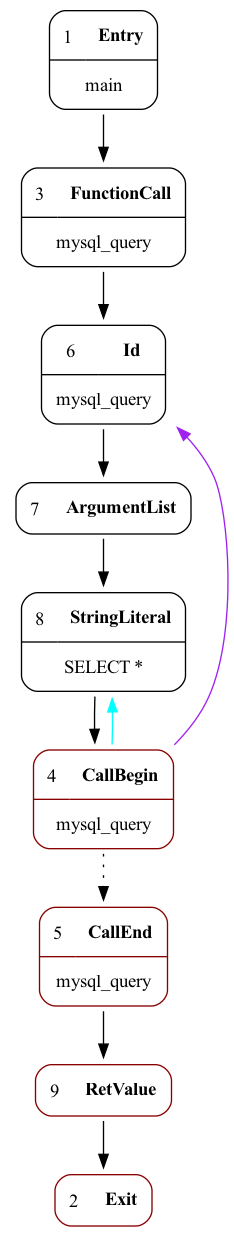

In [152]:
ast = reader.read_ast("../part_1/functioncall/functioncall.php.ast.json")
cfg = ASTtoCFGVisitor.visit(ast)
show_cfg(cfg)

Visit AST from file code.php
Generic visit for IntegerLiteral
Generic visit for Variable
Generic visit for Variable
Generic visit for IntegerLiteral
Generic visit for EchoStatement
Generic visit for ArgumentList
Generic visit for StringExpression
Generic visit for EchoStatement
Generic visit for ArgumentList
Generic visit for StringExpression


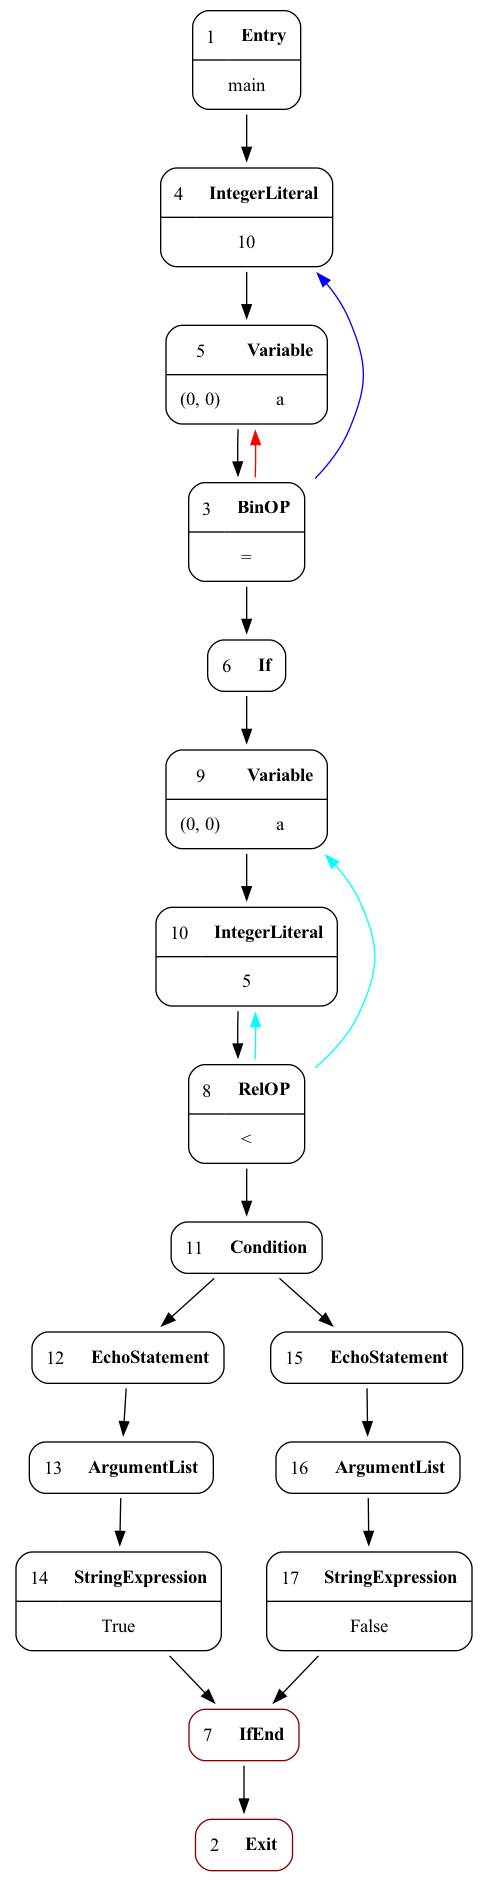

In [153]:
ast = reader.read_ast("../part_1/if/if.php.ast.json")
cfg = ASTtoCFGVisitor.visit(ast)
show_cfg(cfg)